In [219]:
from prophet import Prophet
from prophet.utilities import regressor_coefficients
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import OneHotEncoder
import joblib
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from lime.lime_tabular import LimeTabularExplainer
import shap
import numpy as np
import json
import seaborn as sns

In [220]:
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [221]:
df = pd.read_pickle('df_neutor_validation.pkl')

In [222]:
df

Datum      Zeit Wochentag  Neutor (gesamt)  Feiertag  Semesterferien  \
0   2023-01-01  00:00:00   Sonntag             73.0         0               1   
1   2023-01-01  01:00:00   Sonntag            193.0         0               1   
2   2023-01-01  02:00:00   Sonntag            240.0         0               1   
3   2023-01-01  03:00:00   Sonntag            279.0         0               1   
4   2023-01-01  04:00:00   Sonntag            194.0         0               1   
..         ...       ...       ...              ...       ...             ...   
163 2023-01-07  19:00:00   Samstag            405.0         0               0   
164 2023-01-07  20:00:00   Samstag            321.0         0               0   
165 2023-01-07  21:00:00   Samstag            238.0         0               0   
166 2023-01-07  22:00:00   Samstag            189.0         0               0   
167 2023-01-07  23:00:00   Samstag            179.0         0               0   

     Ferien  Lockdown  Verkehr_vor_einer_Woche  Verkehrs_Differenz  \
0         1         0                     39.0                34.0   
1         1         0                     34.0               159.0   
2         1         0                     38.0               202.0   
3         1         0                     10.0               269.0   
4         1         0                     15.0               179.0   
..      ...       ...                      ...                 ...   
163       0         0                    365.0                40.0   
164       0         0                    303.0                18.0   
165       0         0                    207.0                31.0   
166       0         0                    149.0                40.0   
167       0         0                    120.0                59.0   

     Neutor_FR_stadtauswärts_vor_einer_Woche  \
0                                       20.0   
1                                       14.0   
2                                       25.0   
3                                       10.0   
4                                        8.0   
..                                       ...   
163                                    192.0   
164                                    139.0   
165                                    105.0   
166                                     66.0   
167                                     49.0   

     Neutor_FR_stadteinwärts_vor_einer_Woche  \
0                                       19.0   
1                                       20.0   
2                                       13.0   
3                                        0.0   
4                                        7.0   
..                                       ...   
163                                    173.0   
164                                    164.0   
165                                    102.0   
166                                     83.0   
167                                     71.0   

     Neutor_FR_stadtauswärts_Differenz  Neutor_FR_stadteinwärts_Differenz  \
0                                 23.0                               11.0   
1                                 89.0                               70.0   
2                                117.0                               85.0   
3                                151.0                              118.0   
4                                129.0                               50.0   
..                                 ...                                ...   
163                               23.0                               17.0   
164                               11.0                                7.0   
165                               34.0                               -3.0   
166                               48.0                               -8.0   
167                               41.0                               18.0   

     Top4_letzte_Woche  Berufsverkehr Jahreszeit  
0                False          False     Winter  
1             

#### Daten vorbereiten

In [223]:
df['Zeit'] = pd.to_datetime(df['Zeit'], format='%H:%M:%S').dt.time
df['Stunden'] = df['Zeit'].apply(lambda x: x.hour + x.minute / 60)

In [224]:
df = df.rename(columns={"Datum": "ds", "Neutor (gesamt)": "y"})

In [225]:
encoder = joblib.load('model_metadata/encoder_prophet.pkl')

categorical_columns = ['Wochentag', 'Jahreszeit', 'Top4_letzte_Woche', 'Berufsverkehr']

# Benutzen Sie den bereits erstellten und trainierten Encoder, um die Daten zu transformieren
encoded_new_data = encoder.transform(df[categorical_columns])
encoded_columns = encoder.get_feature_names_out(categorical_columns)

# Hinzufügen der kodierten Spalten zum DataFrame
df_encoded = df.join(pd.DataFrame(encoded_new_data.toarray(), columns=encoded_columns, index=df.index))

#### Model laden und anwenden

In [226]:
with open('model_metadata/prophet_metadata.json', 'r') as file:
    metadata = json.load(file)

additional_regressors = metadata['additional_regressors']

In [227]:
with open('prophet_model_without_weather.pkl', 'rb') as f:
    model = pickle.load(f)

In [228]:
train_prophet = pd.read_pickle("model_metadata/train_prophet.pkl")

In [229]:
# Vorbereitung des DataFrames für Prophet
df_prophet = df_encoded[['ds', 'y'] + additional_regressors].copy()
df_prophet['floor'] = 0
df_prophet['cap'] = 1.5 * train_prophet['y'].max()

In [230]:
df_prophet

ds      y  Feiertag  Semesterferien  Ferien  Lockdown  \
0   2023-01-01   73.0         0               1       1         0   
1   2023-01-01  193.0         0               1       1         0   
2   2023-01-01  240.0         0               1       1         0   
3   2023-01-01  279.0         0               1       1         0   
4   2023-01-01  194.0         0               1       1         0   
..         ...    ...       ...             ...     ...       ...   
163 2023-01-07  405.0         0               0       0         0   
164 2023-01-07  321.0         0               0       0         0   
165 2023-01-07  238.0         0               0       0         0   
166 2023-01-07  189.0         0               0       0         0   
167 2023-01-07  179.0         0               0       0         0   

     Verkehr_vor_einer_Woche  Verkehrs_Differenz  \
0                       39.0                34.0   
1                       34.0               159.0   
2                       38.0               202.0   
3                       10.0               269.0   
4                       15.0               179.0   
..                       ...                 ...   
163                    365.0                40.0   
164                    303.0                18.0   
165                    207.0                31.0   
166                    149.0                40.0   
167                    120.0                59.0   

     Neutor_FR_stadtauswärts_vor_einer_Woche  \
0                                       20.0   
1                                       14.0   
2                                       25.0   
3                                       10.0   
4                                        8.0   
..                                       ...   
163                                    192.0   
164                                    139.0   
165                                    105.0   
166                                     66.0   
167                                     49.0   

     Neutor_FR_stadteinwärts_vor_einer_Woche  ...  Jahreszeit_Frühling  \
0                                       19.0  ...                  0.0   
1                                       20.0  ...                  0.0   
2                                       13.0  ...                  0.0   
3                                        0.0  ...                  0.0   
4                                        7.0  ...                  0.0   
..                                       ...  ...                  ...   
163                                    173.0  ...                  0.0   
164                                    164.0  ...                  0.0   
165                                    102.0  ...                  0.0   
166                                     83.0  ...                  0.0   
167                                     71.0  ...                  0.0   

     Jahreszeit_Herbst  Jahreszeit_Sommer  Jahreszeit_Winter  \
0                  0.0                0.0                1.0   
1                  0.0                0.0                1.0   
2                  0.0                0.0                1.0   
3                  0.0                0.0                1.0   
4                  0.0                0.0                1.0   
..                 ...                ...                ...   
163                0.0                0.0                1.0   
164                0.0                0.0                1.0   
165                0.0                0.0                1.0   
166                0.0                0.0                1.0   
167                0.0                0.0                1.0   

     Top4_letzte_Woche_False  Top4_letzte_Woche_True  Berufsverkehr_False  \
0                        1.0                     0.0                  1.0   
1                        1.0                     0.0                  1.0   
2                        1.0                     0.0                  1.0   
3              

In [231]:
forecast = model.predict(df_prophet)

The figure layout has changed to tight


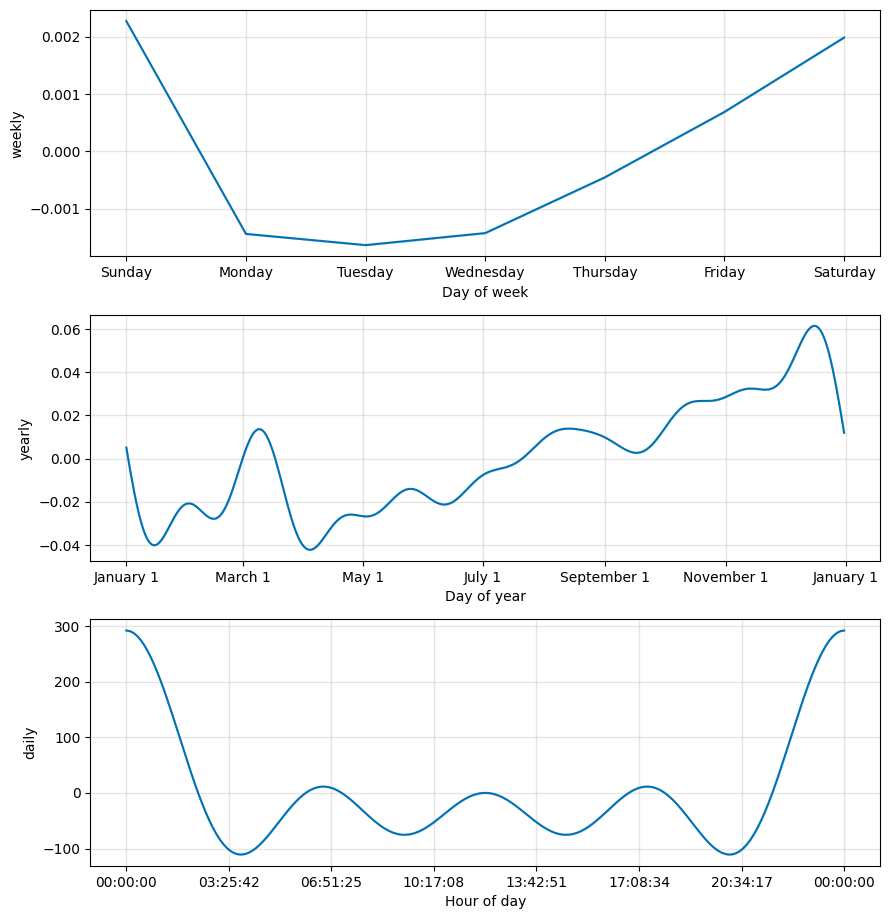

In [280]:
fig_components = model.plot_components(forecast)

ax_to_remove = [fig_components.axes[0], fig_components.axes[1], fig_components.axes[5]]  # Welche Plots
for ax in ax_to_remove:
    fig_components.delaxes(ax)

plt.tight_layout()

plt.savefig("visualization/prophet_weekly_yearl_daily.png", dpi=300, bbox_inches="tight")

plt.show()

In [232]:
results_df = pd.read_csv('model_metadata/lstm_gru_predictions.csv')

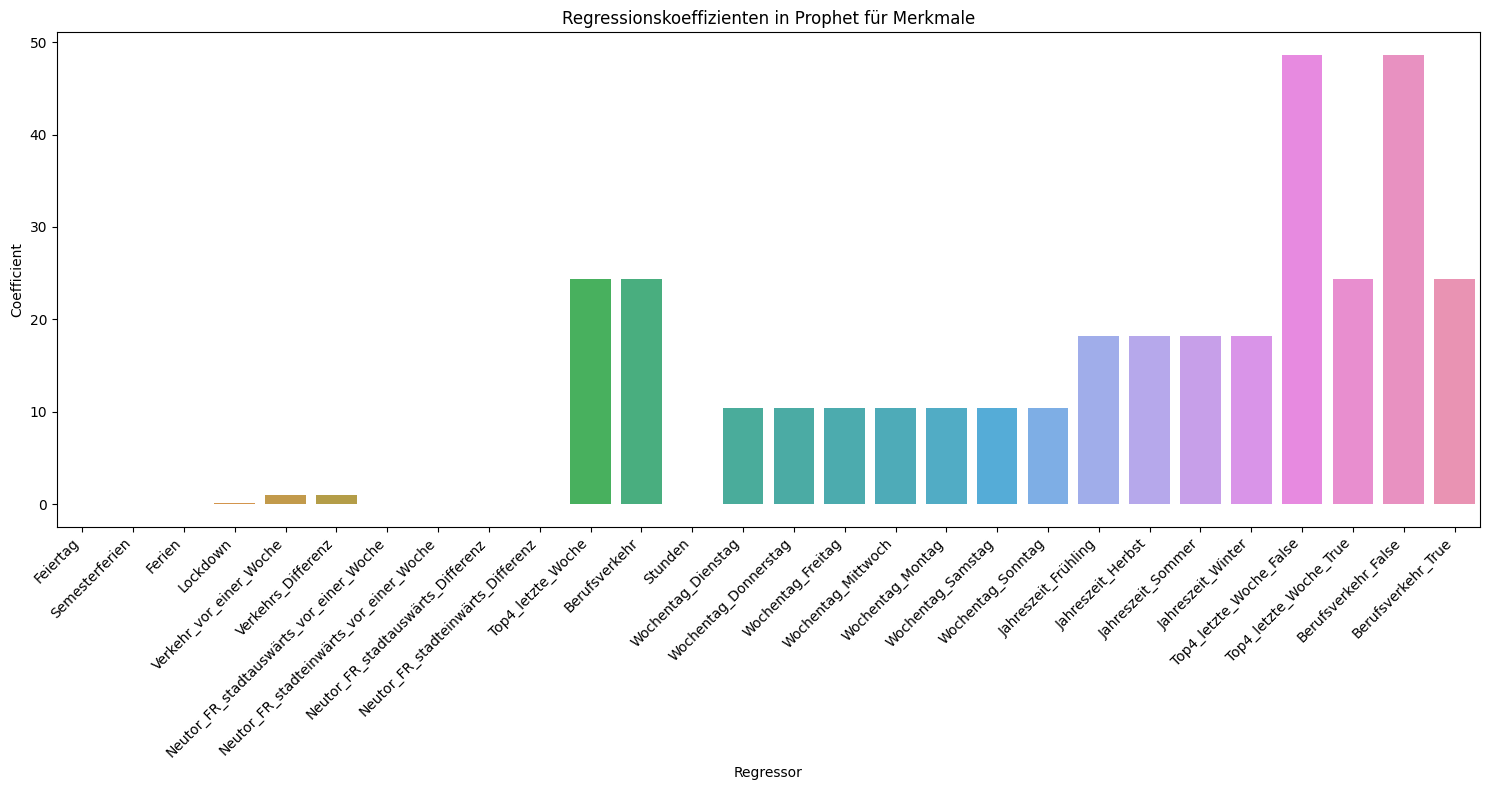

In [238]:
coef = regressor_coefficients(model)
coef_df = pd.DataFrame(coef)
coef_df['regressor'] = coef_df['regressor'].apply(lambda x: x[0] if isinstance(x, list) else x)
coef_df = coef_df[coef_df['regressor'].isin(additional_regressors)]  

# Barplot der Koeffizienten
plt.figure(figsize=(15, 8))
sns.barplot(x='regressor', y='coef', data=coef_df)
plt.title("Regressionskoeffizienten in Prophet für Merkmale")
plt.xlabel("Regressor")
plt.ylabel("Coefficient")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.savefig("visualization/prophet_merkmale.png", dpi=300, bbox_inches="tight")

plt.show()

In [234]:
prophet_predictions = forecast['yhat'].values[10:]
results_df['prophet_predictions'] = prophet_predictions

In [235]:
results_df

y_original  lstm_predictions  gru_predictions  prophet_predictions
0          26.0         146.02325        106.44344           115.745222
1          55.0         150.16147        118.09157           114.745448
2         115.0         158.44676        128.98787           152.742446
3         116.0         156.09186        173.24990            25.743544
4         165.0         161.56934        185.95087            54.743408
..          ...               ...              ...                  ...
153       405.0         406.16046        325.57400           136.745442
154       321.0         440.59998        284.74527           178.746314
155       238.0         315.02682        288.50810           188.741085
156       189.0         236.08133        245.59871           319.742784
157       179.0         186.25388        198.37675           178.740272

[158 rows x 4 columns]

## XGBoost und Random Forest

In [318]:
df_tree = pd.read_pickle('df_neutor_validation.pkl')

In [293]:
with open('best_random_forest_model_without_weather.pkl', 'rb') as rf_model_file:
    best_model_rf = pickle.load(rf_model_file)

In [294]:
with open('best_xgboost_model_without_weather.pkl', 'rb') as xgb_model_file:
    best_model_xgb = pickle.load(xgb_model_file)

In [319]:
df_tree['Jahr'] = df_tree['Datum'].dt.year
df_tree['Monat'] = df_tree['Datum'].dt.month
df_tree['Tag'] = df_tree['Datum'].dt.day
df_tree['Zeit'] = df_tree['Zeit'].astype(str)
df_tree['Stunde'] = df_tree['Zeit'].str.split(':').str[0].astype(int)
df_tree = pd.concat([df_tree, pd.get_dummies(df_tree['Wochentag'], prefix='Wochentag')], axis=1)
df_tree['Jahreszeit_Frühling'] = False
df_tree['Jahreszeit_Herbst'] = False
df_tree['Jahreszeit_Sommer'] = False
df_tree = pd.concat([df_tree, pd.get_dummies(df_tree['Jahreszeit'], prefix='Jahreszeit')], axis=1)
df_tree['Berufsverkehr'] = df_tree['Berufsverkehr'].astype(int)

In [325]:
features = ['Feiertag','Semesterferien', 'Ferien', 'Lockdown', 'Verkehr_vor_einer_Woche',
            'Verkehrs_Differenz', 'Neutor_FR_stadtauswärts_vor_einer_Woche',
            'Neutor_FR_stadteinwärts_vor_einer_Woche',
            'Neutor_FR_stadtauswärts_Differenz',
            'Neutor_FR_stadteinwärts_Differenz', 'Top4_letzte_Woche',
            'Berufsverkehr', 'Jahr', 'Monat', 'Tag',
            'Wochentag_Dienstag', 'Wochentag_Donnerstag', 'Wochentag_Freitag',
            'Wochentag_Mittwoch', 'Wochentag_Montag', 'Wochentag_Samstag',
            'Wochentag_Sonntag', 'Stunde','Jahreszeit_Frühling',
            'Jahreszeit_Herbst', 'Jahreszeit_Sommer', 'Jahreszeit_Winter']

In [326]:
rf_preds = best_model_rf.predict(df_tree[features])  
xgb_preds = best_model_xgb.predict(df_tree[features]) 

In [327]:
temp_df = df_tree.copy() 
temp_df['random_forest_predictions'] = rf_preds
temp_df['xgboost_predictions'] = xgb_preds

In [328]:
temp_df

Datum      Zeit Wochentag  Neutor (gesamt)  Feiertag  Semesterferien  \
0   2023-01-01  00:00:00   Sonntag             73.0         0               1   
1   2023-01-01  01:00:00   Sonntag            193.0         0               1   
2   2023-01-01  02:00:00   Sonntag            240.0         0               1   
3   2023-01-01  03:00:00   Sonntag            279.0         0               1   
4   2023-01-01  04:00:00   Sonntag            194.0         0               1   
..         ...       ...       ...              ...       ...             ...   
163 2023-01-07  19:00:00   Samstag            405.0         0               0   
164 2023-01-07  20:00:00   Samstag            321.0         0               0   
165 2023-01-07  21:00:00   Samstag            238.0         0               0   
166 2023-01-07  22:00:00   Samstag            189.0         0               0   
167 2023-01-07  23:00:00   Samstag            179.0         0               0   

     Ferien  Lockdown  Verkehr_vor_einer_Woche  Verkehrs_Differenz  ...  \
0         1         0                     39.0                34.0  ...   
1         1         0                     34.0               159.0  ...   
2         1         0                     38.0               202.0  ...   
3         1         0                     10.0               269.0  ...   
4         1         0                     15.0               179.0  ...   
..      ...       ...                      ...                 ...  ...   
163       0         0                    365.0                40.0  ...   
164       0         0                    303.0                18.0  ...   
165       0         0                    207.0                31.0  ...   
166       0         0                    149.0                40.0  ...   
167       0         0                    120.0                59.0  ...   

     Wochentag_Mittwoch  Wochentag_Montag  Wochentag_Samstag  \
0                 False             False              False   
1                 False             False              False   
2                 False             False              False   
3                 False             False              False   
4                 False             False              False   
..                  ...               ...                ...   
163               False             False               True   
164               False             False               True   
165               False             False               True   
166               False             False               True   
167               False             False               True   

     Wochentag_Sonntag  Jahreszeit_Frühling  Jahreszeit_Herbst  \
0                 True                False              False   
1                 True                False              False   
2                 True                False              False   
3                 True                False              False   
4                 True                False              False   
..                 ...                  ...                ...   
163              False                False              False   
164              False                False              False   
165              False                False              False   
166              False                False              False   
167              False                False              False   

    Jahreszeit_Sommer  Jahreszeit_Winter  random_forest_predictions  \
0               False               True                  72.892633   
1               False               True                 190.284430   
2               False               True                 235.232534   
3               False               True                 291.842105   
4               False               True                 192.180921   
..                ...                ...                        ...   
163             False               True                 403.826082   
164  

In [329]:
df_plot = df_tree.copy()
df_plot['Datum'] = df_plot['Datum'].astype(str)
df_plot['Zeit'] = df_plot['Zeit'].astype(str)

rf_preds_trimmed = rf_preds[10:]
xgb_preds_trimmed = xgb_preds[10:]
date_time = df_plot['Datum'] + ' ' + df_plot['Zeit']
date_time = date_time[10:]
date_time = date_time.reset_index(drop=True)

In [330]:
# Hinzufügen der Vorhersagen zu results_df
results_df['random_forest_predictions'] = rf_preds_trimmed
results_df['xgboost_predictions'] = xgb_preds_trimmed
results_df['DatumZeit'] = date_time
results_df['DatumZeit'] = pd.to_datetime(results_df['DatumZeit'])

In [331]:
results_df

y_original  lstm_predictions  gru_predictions  prophet_predictions  \
0          26.0         146.02325        106.44344           115.745222   
1          55.0         150.16147        118.09157           114.745448   
2         115.0         158.44676        128.98787           152.742446   
3         116.0         156.09186        173.24990            25.743544   
4         165.0         161.56934        185.95087            54.743408   
..          ...               ...              ...                  ...   
153       405.0         406.16046        325.57400           136.745442   
154       321.0         440.59998        284.74527           178.746314   
155       238.0         315.02682        288.50810           188.741085   
156       189.0         236.08133        245.59871           319.742784   
157       179.0         186.25388        198.37675           178.740272   

     random_forest_predictions  xgboost_predictions           DatumZeit  
0                    26.089738            25.533707 2023-01-01 10:00:00  
1                    54.664856            54.128716 2023-01-01 11:00:00  
2                   115.363652           119.628807 2023-01-01 12:00:00  
3                   115.092105           117.861343 2023-01-01 13:00:00  
4                   166.177371           166.880569 2023-01-01 14:00:00  
..                         ...                  ...                 ...  
153                 403.826082           404.465332 2023-01-07 19:00:00  
154                 320.059007           318.492371 2023-01-07 20:00:00  
155                 236.402180           239.185333 2023-01-07 21:00:00  
156                 188.767803           188.705521 2023-01-07 22:00:00  
157                 178.277193           175.158615 2023-01-07 23:00:00  

[158 rows x 7 columns]

#### Performance Metriken berechnen

In [332]:
y_true = results_df['y_original'].values

# LSTM
y_pred_lstm = results_df['lstm_predictions'].values
mae_lstm = mae(y_true, y_pred_lstm)
rmse_lstm = rmse(y_true, y_pred_lstm)
smape_lstm = smape(y_true, y_pred_lstm)

# GRU
y_pred_gru = results_df['gru_predictions'].values
mae_gru = mae(y_true, y_pred_gru)
rmse_gru = rmse(y_true, y_pred_gru)
smape_gru = smape(y_true, y_pred_gru)

# Prophet
y_pred_prophet = results_df['prophet_predictions'].values
mae_prophet = mae(y_true, y_pred_prophet)
rmse_prophet = rmse(y_true, y_pred_prophet)
smape_prophet = smape(y_true, y_pred_prophet)

# XGBoost
y_pred_xgb = results_df['xgboost_predictions'].values
mae_xgb = mae(y_true, y_pred_xgb)
rmse_xgb = rmse(y_true, y_pred_xgb)
smape_xgb = smape(y_true, y_pred_xgb)

# Random Forest
y_pred_rf = results_df['random_forest_predictions'].values
mae_rf = mae(y_true, y_pred_rf)
rmse_rf = rmse(y_true, y_pred_rf)
smape_rf = smape(y_true, y_pred_rf)

print("LSTM - MAE:", mae_lstm)
print("LSTM - RMSE:", rmse_lstm)
print("LSTM - SMAPE:", smape_lstm)

print("\nGRU - MAE:", mae_gru)
print("GRU - RMSE:", rmse_gru)
print("GRU - SMAPE:", smape_gru)

print("\nProphet - MAE:", mae_prophet)
print("Prophet - RMSE:", rmse_prophet)
print("Prohet - SMAPE:", smape_prophet)

print("\nXGB - MAE:", mae_xgb)
print("XGB - RMSE:", rmse_xgb)
print("XGB - SMAPE:", smape_xgb)

print("\nRF - MAE:", mae_rf)
print("RF - RMSE:", rmse_rf)
print("RF - SMAPE:", smape_rf)

LSTM - MAE: 39.37581342170886
LSTM - RMSE: 51.67509601503181
LSTM - SMAPE: 34.4051449996404

GRU - MAE: 47.13559167721519
GRU - RMSE: 56.31157494513733
GRU - SMAPE: 35.5100102868953

Prophet - MAE: 235.89969959594058
Prophet - RMSE: 289.9061232160912
Prohet - SMAPE: 104.41477344456607

XGB - MAE: 2.89593214324758
XGB - RMSE: 4.3861393157302855
XGB - SMAPE: 1.964083122106631

RF - MAE: 2.269265071551504
RF - RMSE: 4.603000955225183
RF - SMAPE: 1.3724165844027294


In [333]:
results = {
    'PROPHET': {
        'MAE': mae_prophet,
        'RMSE': rmse_prophet,
        'SMAPE': smape_prophet,
    },
    'XGBOOST': {
        'MAE': mae_xgb,
        'RMSE': rmse_xgb,
        'SMAPE': smape_xgb,
    },
    'RANDOM FOREST': {
        'MAE': mae_rf,
        'RMSE': rmse_rf,
        'SMAPE': smape_rf,
    },
    'LSTM': {
        'MAE': mae_lstm,
        'RMSE': rmse_lstm,
        'SMAPE': smape_lstm,
    },
    'GRU': {
        'MAE': mae_gru,
        'RMSE': rmse_gru,
        'SMAPE': smape_gru,
    }
}

In [334]:
results_metrics_df = pd.DataFrame(columns=['Model', 'MAE', 'RMSE', 'SMAPE'])

for model, metrics in results.items():
    new_row = {'Model': model, 'MAE': metrics['MAE'], 'RMSE': metrics['RMSE'], 'SMAPE': metrics['SMAPE']}
    results_metrics_df.loc[len(results_metrics_df)] = new_row
    
results_metrics_df.to_csv('model_metadata/model_results.csv', index=False)

In [335]:
results_metrics_df

Model         MAE        RMSE       SMAPE
0        PROPHET  235.899700  289.906123  104.414773
1        XGBOOST    2.895932    4.386139    1.964083
2  RANDOM FOREST    2.269265    4.603001    1.372417
3           LSTM   39.375813   51.675096   34.405145
4            GRU   47.135592   56.311575   35.510010

<Figure size 1500x600 with 0 Axes>

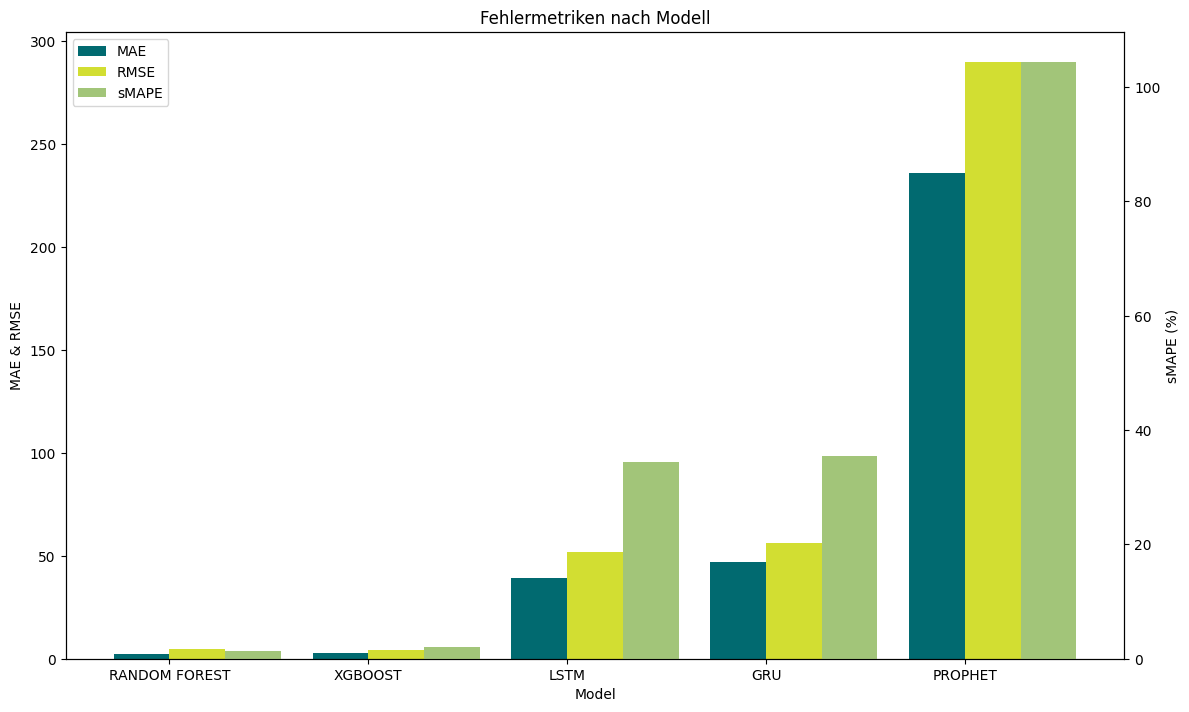

In [336]:
plt.figure(figsize=(15, 6))

results_metrics_df = results_metrics_df.set_index('Model')
results_metrics_df = results_metrics_df.reindex(['RANDOM FOREST', 'XGBOOST', 'LSTM', 'GRU', 'PROPHET']).reset_index()

labels = results_metrics_df['Model'].values
mae_vals = results_metrics_df['MAE'].values
rmse_vals = results_metrics_df['RMSE'].values
smape_vals = results_metrics_df['SMAPE'].values

x = np.arange(len(labels))
width = 0.28

fig, ax1 = plt.subplots(figsize=(12,7))

# MAE und RMSE auf der linken Achse
rects1 = ax1.bar(x - width/2, mae_vals, width, label='MAE', color='#016A70')
rects2 = ax1.bar(x + width/2, rmse_vals, width, label='RMSE', color='#D2DE32')
ax1.set_xlabel('Model')
ax1.set_ylabel('MAE & RMSE', color='black')
ax1.tick_params('y', colors='black')
ax1.set_xticks(x)
ax1.set_xticklabels(labels)

# SMAPE auf der rechten Achse
ax2 = ax1.twinx()
rects3 = ax2.bar(x + 1.5*width, smape_vals, width, label='sMAPE', color='#A2C579')
ax2.set_ylabel('sMAPE (%)', color='black')
ax2.tick_params('y', colors='black')

fig.tight_layout()
handles, labels = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

ax1.legend(handles + handles2, labels + labels2, loc='upper left')

plt.title('Fehlermetriken nach Modell')

plt.savefig("visualization/Fehlermetriken_23.png", dpi=300, bbox_inches='tight')

plt.show()

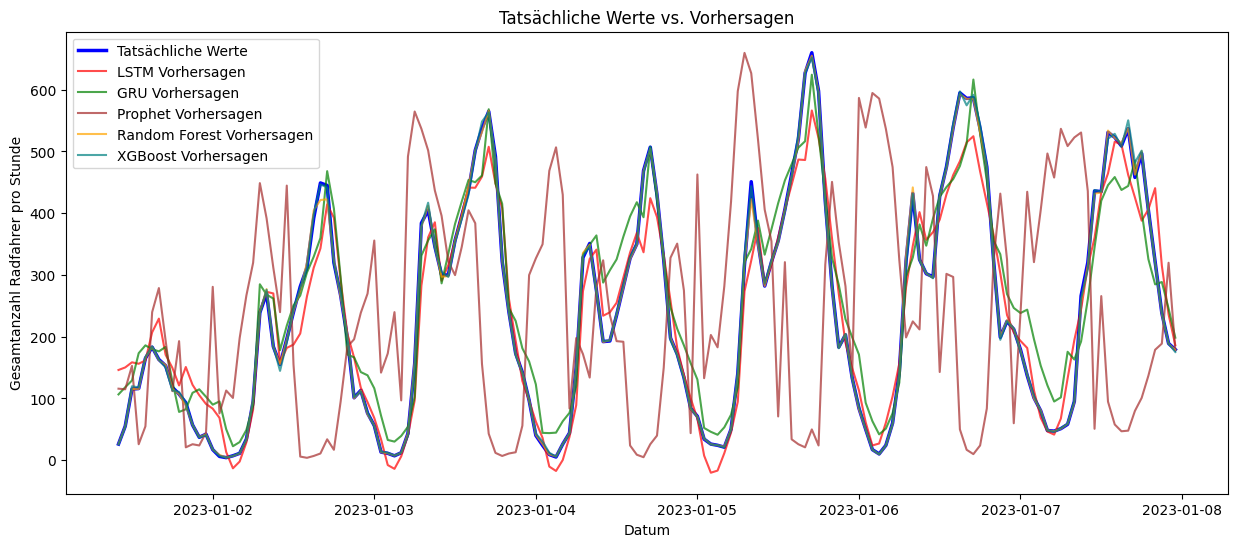

In [347]:
plt.figure(figsize=(15, 6))

# Tatsächliche Werte
plt.plot(results_df['DatumZeit'], results_df['y_original'], label='Tatsächliche Werte', color='blue', linewidth=2.5)

# LSTM-Vorhersagen
plt.plot(results_df['DatumZeit'], results_df['lstm_predictions'], label='LSTM Vorhersagen', color='red', alpha=0.7)

# GRU-Vorhersagen
plt.plot(results_df['DatumZeit'], results_df['gru_predictions'], label='GRU Vorhersagen', color='green', alpha=0.7)

# Prophet-Vorhersage
plt.plot(results_df['DatumZeit'], results_df['prophet_predictions'], label='Prophet Vorhersagen', color='brown', alpha=0.7)

# Random Forest-Vorhersage
plt.plot(results_df['DatumZeit'], results_df['random_forest_predictions'], label='Random Forest Vorhersagen', color='orange', alpha=0.7)

# Random Forest-Vorhersage
plt.plot(results_df['DatumZeit'], results_df['xgboost_predictions'], label='XGBoost Vorhersagen', color='teal', alpha=0.7)

plt.title('Tatsächliche Werte vs. Vorhersagen')
plt.ylabel('Gesamtanzahl Radfahrer pro Stunde')
plt.xlabel('Datum')
plt.legend()

plt.savefig("visualization/Vorhersage_23.png", dpi=300, bbox_inches='tight')

plt.show()


### XAI fuer Random Forest und XGBoost

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


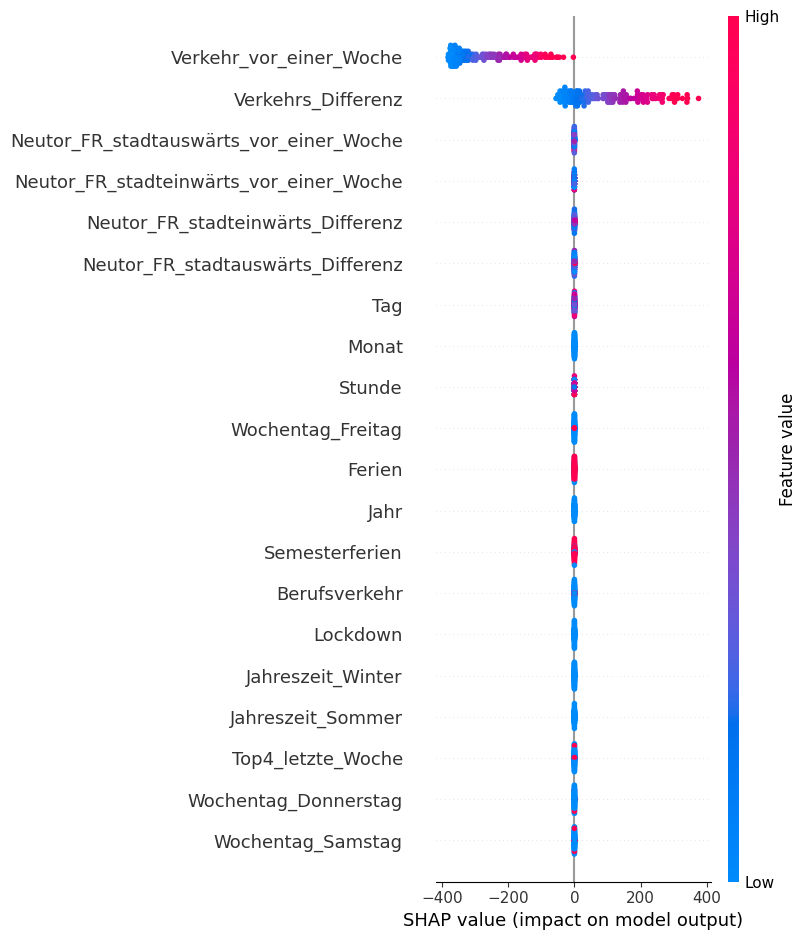

In [339]:
# Erstellen Sie ein SHAP-Explainer-Objekt
explainer_xgb = shap.Explainer(best_model_xgb)

# Berechnen Sie SHAP-Werte für Ihre Daten
shap_values_xgb = explainer_xgb(df_tree[features])

# Plot
shap.summary_plot(shap_values_xgb, df_tree[features])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


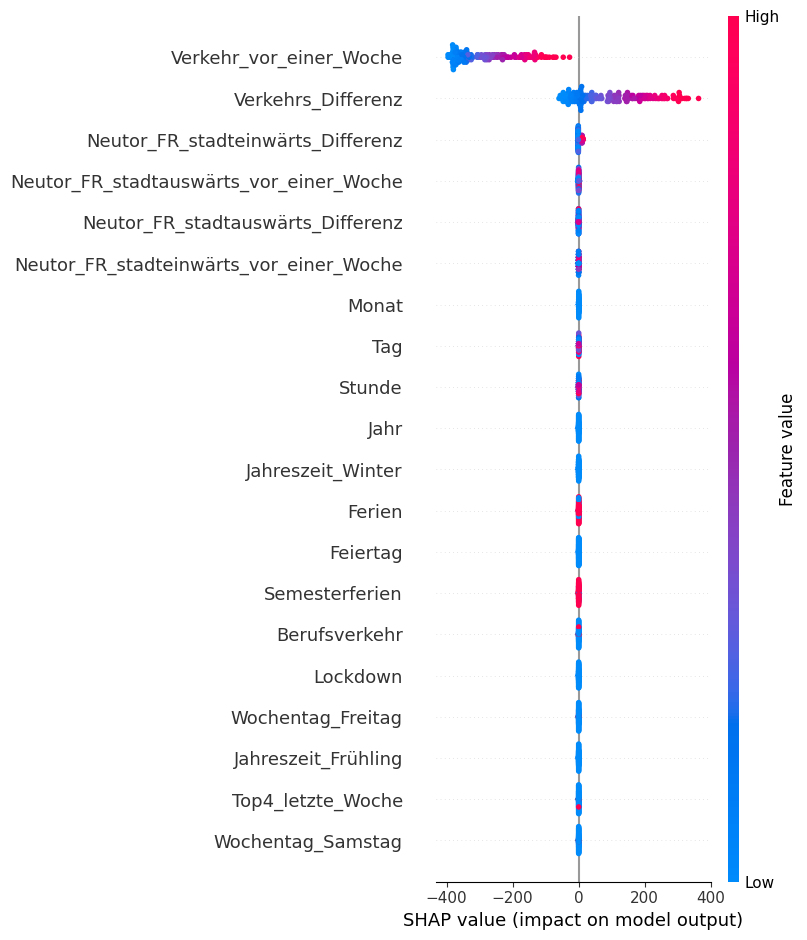

In [340]:
# Erstellen Sie ein SHAP-TreeExplainer-Objekt
explainer_rf = shap.TreeExplainer(best_model_rf)

# Berechnen Sie SHAP-Werte für Ihre Daten
shap_values_rf = explainer_rf.shap_values(df_tree[features])

# Plot
shap.summary_plot(shap_values_rf, df_tree[features])

#### LIME

In [341]:
# Explainer für Regression
explainer_xgb = LimeTabularExplainer(df_tree[features].values, 
                                     feature_names=features, 
                                     mode='regression')

# i = Zeitpunkt in dem DF
i = 150
exp_xgb = explainer_xgb.explain_instance(df_tree[features].iloc[i].values, best_model_xgb.predict)
exp_xgb.show_in_notebook()

fig = exp_xgb.as_pyplot_figure()

plt.title('LIME-Erklärung für XGBoost')

plt.tight_layout()

plt.savefig('visualization/lime_xgb.png', bbox_inches='tight', dpi=1000)

plt.close()

In [289]:
print(df_tree.iloc[150])

Datum                                      2023-01-07 00:00:00
Zeit                                                  06:00:00
Wochentag                                              Samstag
Neutor (gesamt)                                           51.0
Feiertag                                                     0
Semesterferien                                               0
Ferien                                                       0
Lockdown                                                     0
Verkehr_vor_einer_Woche                                   26.0
Verkehrs_Differenz                                        25.0
Neutor_FR_stadtauswärts_vor_einer_Woche                   13.0
Neutor_FR_stadteinwärts_vor_einer_Woche                   13.0
Neutor_FR_stadtauswärts_Differenz                         18.0
Neutor_FR_stadteinwärts_Differenz                          7.0
Top4_letzte_Woche                                        False
Berufsverkehr                                          

In [342]:
# Explainer für Regression
explainer_rf = LimeTabularExplainer(df_tree[features].values, 
                                     feature_names=features, 
                                     mode='regression')

# i = Zeitpunkt in dem DF
i = 150
exp_rf = explainer_rf.explain_instance(df_tree[features].iloc[i].values, best_model_rf.predict)
exp_rf.show_in_notebook()

fig = exp_rf.as_pyplot_figure()

plt.title('LIME-Erklärung für Random Forest')

plt.tight_layout()

plt.savefig('visualization/lime_rf.png', bbox_inches='tight', dpi=1000)

plt.close()

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


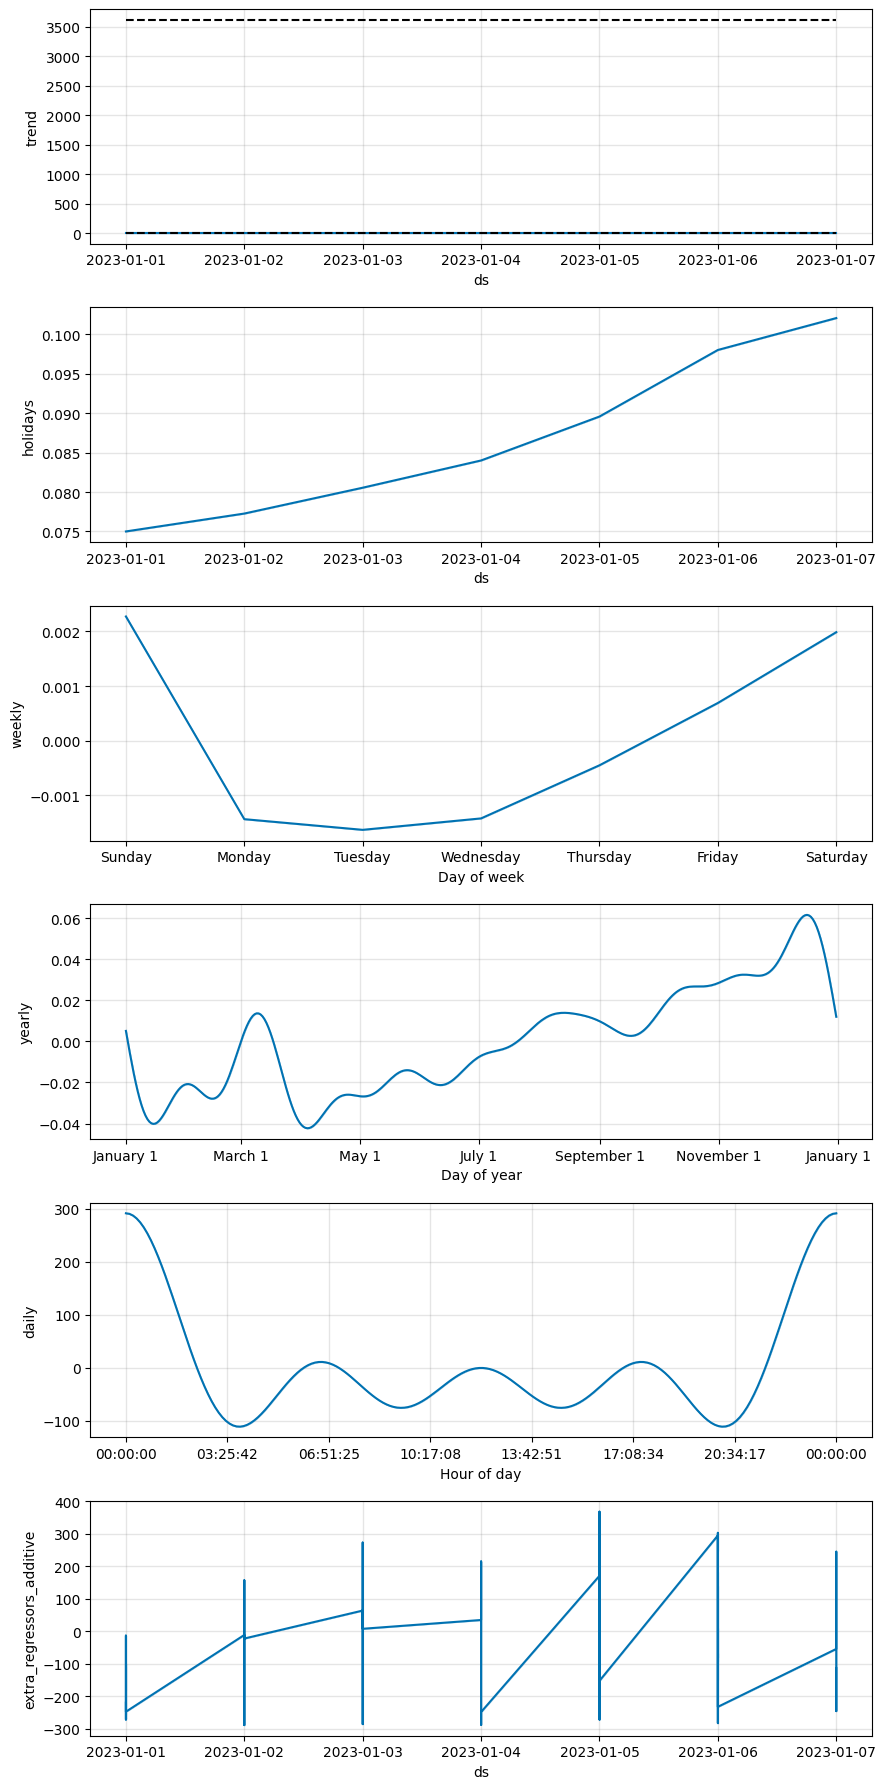

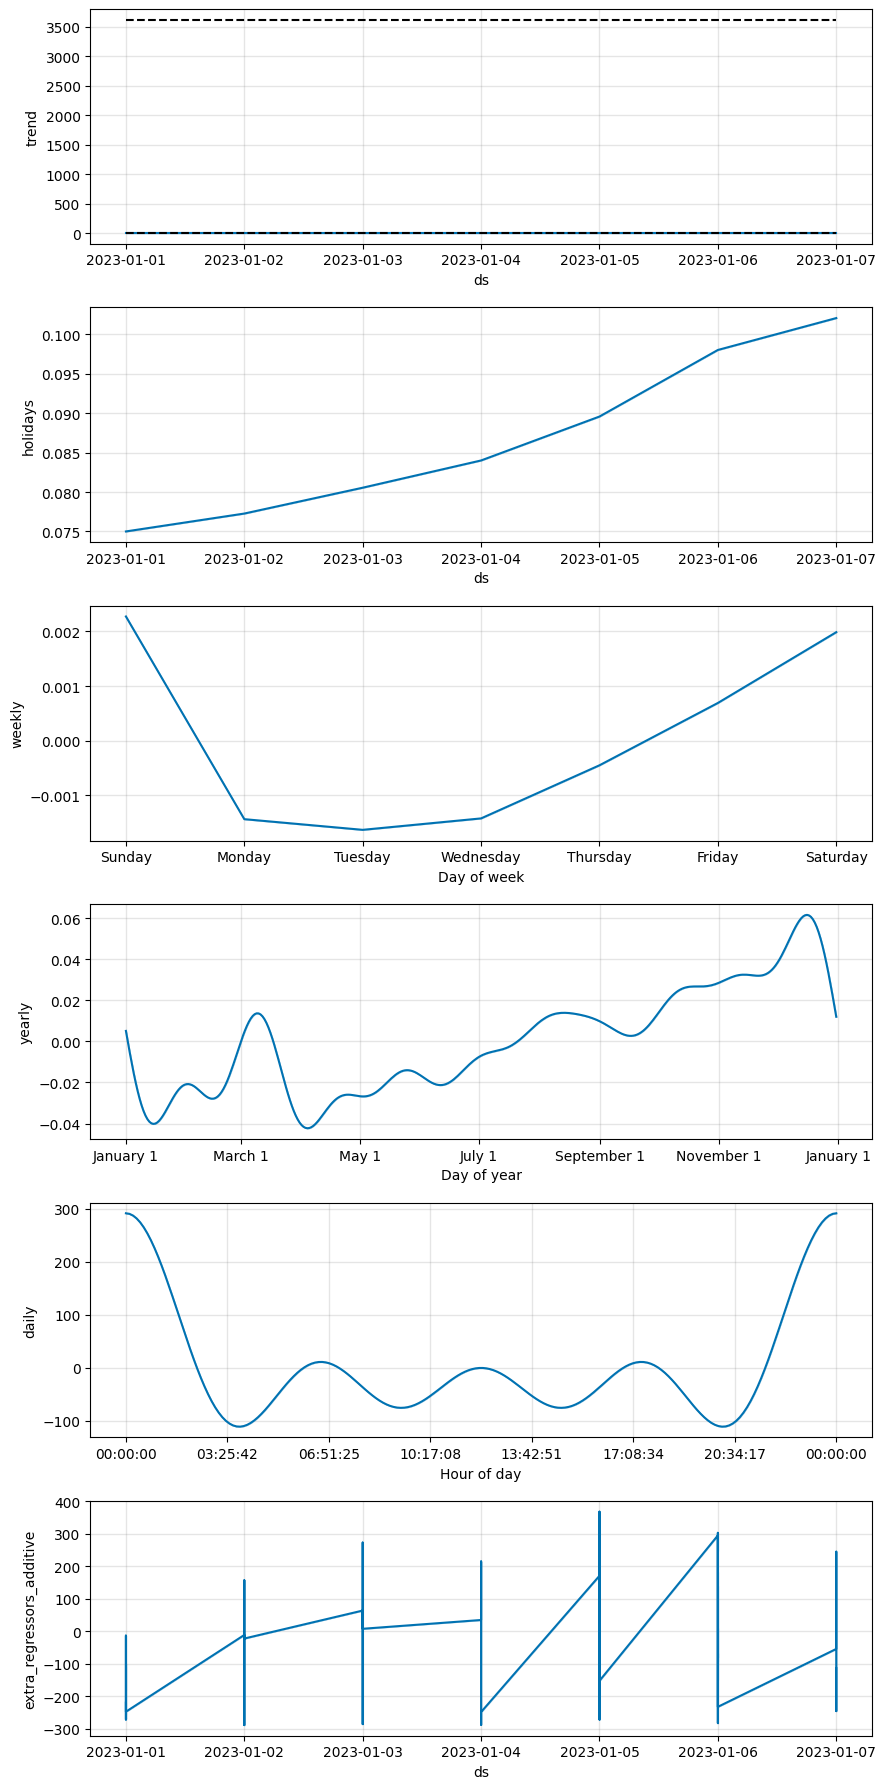

In [ ]:
#model.plot(forecast)
model.plot_components(forecast)

### Plots zusammenfügen

In [343]:
import matplotlib.pyplot as plt
from PIL import Image

# Lade die einzelnen Plot-Bilder für alle Modelle
lime_rf = Image.open('visualization/lime_rf.png')
lime_xgb = Image.open('visualization/lime_xgb.png')
lime_lstm = Image.open('visualization/lime_lstm.png')
lime_gru = Image.open('visualization/lime_gru.png')

# Passe die Bildgrößen an, um einheitliche Höhe und Breite zu erreichen
image_width = min(lime_rf.width, lime_xgb.width, lime_lstm.width, lime_gru.width)
image_height = min(lime_rf.height, lime_xgb.height, lime_lstm.height, lime_gru.height)

# Erstelle ein leeres großes Bild
large_image = Image.new('RGB', (2 * image_width, 2 * image_height), color='white')

# Füge die einzelnen Plot-Bilder zum großen Bild hinzu (2x2-Raster)
large_image.paste(lime_rf.resize((image_width, image_height)), (0, 0))
large_image.paste(lime_xgb.resize((image_width, image_height)), (image_width, 0))
large_image.paste(lime_lstm.resize((image_width, image_height)), (0, image_height))
large_image.paste(lime_gru.resize((image_width, image_height)), (image_width, image_height))

# Speichere das große Bild
large_image.save('visualization/all_plots_lime.png', dpi=(1000,1000))
